In [17]:
!pip install fuzzy

In [18]:
from fuzzy import *
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import numpy as np


In [19]:
df = pd.read_csv('iris.data', header=None, names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])

df = df[~(df['class']=='Iris-virginica')]

df.head()

df.replace(to_replace='Iris-setosa', value=0, inplace=True)

df.replace(to_replace='Iris-versicolor', value=1, inplace=True)

df = df.sample(frac=1)

X_train = df[['sepal length', 'petal length']].values
Y_train = df['class'].values

_max = np.max(X_train, axis=0)
_min = np.min(X_train, axis=0)
X_train = (X_train - _min) / (_max - _min)

X_test, Y_test = X_train[-20:], Y_train[-20:]
X_train, Y_train = X_train[:-20], Y_train[:-20]

In [20]:
df

,sepal length,sepal width,petal length,petal width,class
20,5.4,3.4,1.7,0.2,0
95,5.7,3.0,4.2,1.2,1
82,5.8,2.7,3.9,1.2,1
49,5.0,3.3,1.4,0.2,0
80,5.5,2.4,3.8,1.1,1
...,...,...,...,...,...
75,6.6,3.0,4.4,1.4,1
91,6.1,3.0,4.6,1.4,1
38,4.4,3.0,1.3,0.2,0
79,5.7,2.6,3.5,1.0,1


In [21]:
class FuzzyMMC:

	def __init__(self, sensitivity=1, exp_bound=1, animate=False):
		self.sensitivity = sensitivity
		self.hyperboxes = None
		self.isanimate = animate
		self.classes = np.array([])
		self.exp_bound = exp_bound

		if self.animate:
			self.box_history = []
			self.train_patterns = []


	def membership(self, pattern):
		min_pts = self.hyperboxes[:, 0, :]
		max_pts = self.hyperboxes[:, 1, :]
		
		a = np.maximum(0, (1 - np.maximum(0, (self.sensitivity * np.minimum(1, pattern - max_pts)))))
		b = np.maximum(0, (1 - np.maximum(0, (self.sensitivity * np.minimum(1, min_pts - pattern)))))

		return np.sum(a + b, axis=1) / (2 * len(pattern))


	def overlap_contract(self, index):
		contracted = False
		for test_box in range(len(self.hyperboxes)):

			if self.classes[test_box] == self.classes[index]:
				# Ignore same class hyperbox overlap
				continue
	
			expanded_box = self.hyperboxes[index]
			box = self.hyperboxes[test_box]

			## TODO: Refactor for vectorization
			vj, wj = expanded_box
			vk, wk = box

			delta_new = delta_old = 1
			min_overlap_index = -1
			for i in range(len(vj)):
				if vj[i] < vk[i] < wj[i] < wk[i]:
					delta_new = min(delta_old, wj[i] - vk[i])

				elif vk[i] < vj[i] < wk[i] < wj[i]:
					delta_new = min(delta_old, wk[i] - vj[i])

				elif vj[i] < vk[i] < wk[i] < wj[i]:
					delta_new = min(delta_old, min(wj[i] - vk[i], wk[i] - vj[i]))

				elif vk[i] < vj[i] < wj[i] < wk[i]:
					delta_new = min(delta_old, min(wj[i] - vk[i], wk[i] - vj[i]))

				if delta_old - delta_new > 0:
					min_overlap_index = i
					delta_old = delta_new

			if min_overlap_index >= 0:
				i = min_overlap_index
				# We need to contract the expanded box
				if vj[i] < vk[i] < wj[i] < wk[i]:
					vk[i] = wj[i] = (vk[i] + wj[i])/2

				elif vk[i] < vj[i] < wk[i] < wj[i]:
					vj[i] = wk[i] = (vj[i] + wk[i])/2

				elif vj[i] < vk[i] < wk[i] < wj[i]:
					if (wj[i] - vk[i]) > (wk[i] - vj[i]):
						vj[i] = wk[i]

					else:
						wj[i] = vk[i]

				elif vk[i] < vj[i] < wj[i] < wk[i]:
					if (wk[i] - vj[i]) > (wj[i] - vk[i]):
						vk[i] = wj[i]

					else:
						wk[i] = vj[i]

				self.hyperboxes[test_box] = np.array([vk, wk])
				self.hyperboxes[index] = np.array([vj, wj])
				contracted = True

		return contracted



	def train_pattern(self, X, Y):
		target = Y
		
		if target not in self.classes:
			
			# Create a new hyberbox
			if self.hyperboxes is not None:
				self.hyperboxes = np.vstack((self.hyperboxes, np.array([[X, X]])))
				self.classes = np.hstack((self.classes, np.array([target])))

			else:
				self.hyperboxes = np.array([[X, X]])
				self.classes = np.array([target])

			if self.isanimate:
				self.box_history.append(np.copy(self.hyperboxes))
				self.train_patterns.append((X, Y))
		else:
			
			memberships = self.membership(X)
			memberships[np.where(self.classes != target)] = 0
			memberships = sorted(list(enumerate(memberships)), key=lambda x: x[1], reverse=True)
			
			# Expand the most suitable hyperbox
			count = 0
			while True:
				index = memberships[count][0]
				min_new = np.minimum(self.hyperboxes[index, 0, :], X)
				max_new = np.maximum(self.hyperboxes[index, 1, :], X)
				
				if self.exp_bound * len(np.unique(self.classes)) >= np.sum(max_new - min_new):
					self.hyperboxes[index, 0] = min_new
					self.hyperboxes[index, 1] = max_new
					break
				else:
					count += 1

				if count == len(memberships):
					self.hyperboxes = np.vstack((self.hyperboxes, np.array([[X, X]])))
					self.classes = np.hstack((self.classes, np.array([target])))
					index = len(self.hyperboxes) - 1
					break

			# Overlap test
			if self.isanimate:
				self.box_history.append(np.copy(self.hyperboxes))
				self.train_patterns.append((X, Y))

			contracted = self.overlap_contract(index)
			
			if self.isanimate and contracted:	
				self.box_history.append(np.copy(self.hyperboxes))
				self.train_patterns.append((X, Y))


	def fit(self, X, Y):
		'''
		Wrapper for train_pattern
		'''
		for x, y in zip(X, Y):
			self.train_pattern(x, y)


	def predict(self, X):
		'''
		Predict the class of the pattern X
		'''
		classes = np.unique(self.classes)
		results = []
		memberships = self.membership(X)
		max_prediction = 0
		pred_class = 0
		for _class in classes:
			mask = np.zeros((len(self.hyperboxes),))
			mask[np.where(self.classes == _class)] = 1
			p = memberships * mask
			prediction, class_index = np.max(p), np.argmax(p)
			if prediction > max_prediction:
				max_prediction = prediction
				pred_class = class_index

		return max_prediction, self.classes[pred_class] 


	def score(self, X, Y):
		'''
		Scores the classifier
		'''
		count = 0
		for x, y in zip(X, Y):
			_, pred = self.predict(x)
			if y == pred:
				count += 1

		return count / len(Y)


	def animate(self, frame_rate=10, filename='', verbose=True):
		'''
		To make a video of the classifier training.
		NOTE: Only possible when working with 2 dimensional patterns
		'''
		if self.isanimate:
			animator = Animator(box_history=self.box_history,
								train_patterns=self.train_patterns,
								classes=self.classes,
								frame_rate=frame_rate,
								exp_bound=self.exp_bound,
								sensitivity=self.sensitivity,
								filename=filename,
								verbose=verbose)

			animator.animate()

			return animator.filename

		else:
			raise Exception('No animation data was collected! Create a fuzzy classifier instance with animate=True')


In [22]:
model = FuzzyMMC(sensitivity=0.2, exp_bound=0.1, animate=True)

In [23]:
model.fit(X_train, Y_train)

In [24]:
model.score(X_test, Y_test)

1.0

In [25]:
def rand_uniform(x, y):
    return random.random() * (y- x) + x

def gen_circle(num_samples):
    num_samples = num_samples
    radius = 5
    points = []
    noise = 0.5
    
    def get_label(x, y):
        dist = math.sqrt(x ** 2 + y ** 2)
        return 0 if dist < radius * 0.5 else 1
    
    for i in range(num_samples//2):
        r = rand_uniform(0, radius * 0.5)
        angle = rand_uniform(0, 2 * math.pi)
        x = r * math.sin(angle)
        y = r * math.cos(angle)
        noiseX = rand_uniform((-1)*radius, radius) * noise
        noiseY = rand_uniform((-1)*radius, radius) * noise
        #label = get_label(noiseX, noiseY)
        label = 0
        points.append((x, y, label))
    
    for i in range(num_samples // 2):
        r = rand_uniform(radius * 0.7, radius)
        angle = rand_uniform(0, 2 * math.pi)
        x = r * math.sin(angle)
        y = r * math.cos(angle)
        noiseX = rand_uniform((-1)*radius, radius) * noise
        noiseY = rand_uniform((-1)*radius, radius) * noise
        #label = get_label(noiseX, noiseY)
        label = 1
        points.append((x, y, label))
        
    return points

In [26]:
o = gen_circle(100)
o = np.array(o)
train = pd.DataFrame(o)

In [27]:
train_x = []
train_y = []
np.random.shuffle(o)
for i in o:
    train_x.append([i[0], i[1]])
    train_y.append(i[2])

train_x = np.array(train_x)
train_y = np.array(train_y)
_max = np.max(train_x, axis=0)
_min = np.min(train_x, axis=0)
train_x = (train_x - _min) / (_max - _min)
train_x.shape, train_y.shape

((100, 2), (100,))

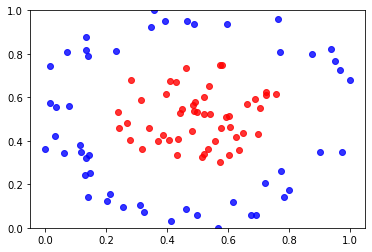

In [28]:
for x, y in zip(train_x, train_y):
    if y == 0:
        plt.scatter(x[0], x[1], c='r', alpha=0.8)
    else:
        plt.scatter(x[0], x[1], c='b', alpha=0.8)
plt.ylim([0, 1])
plt.show()